In [2]:

import pandas as pd

#Read sentences from a text file
def read_file(filename):
    with open(filename, 'r') as f:
        lines = [x.strip() for x in f.readlines()]
        return lines

# load sentences and slot labels into a dataframe
sentences = read_file("deepakData/snips_sentences_subset.txt")
slot_labels = read_file("deepakData/snips_slot_labels_subset.txt")

df = pd.DataFrame(list(zip(sentences, slot_labels)), columns =['sentences', 'slot_labels']) 
df.head()

,sentences,slot_labels
0,Add another song to the Cita RomÃ¡ntica playlist,O O B-music_item O O B-playlist I-playlist O
1,add clem burke in my playlist Pre-Party R&B Jams,O B-artist I-artist O B-playlist_owner O B-pla...
2,Add Live from Aragon Ballroom to Trapeo,O B-entity_name I-entity_name I-entity_name I-...
3,add Unite and Win to my night out,O B-entity_name I-entity_name I-entity_name O ...
4,Add track to my Digster Future Hits,O B-music_item O B-playlist_owner B-playlist I...


In [3]:

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# store seeds
TEST_SPLIT = 0.2
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

#Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(df['sentences'], df['slot_labels'], 
                                                    test_size = TEST_SPLIT, random_state = RANDOM_STATE)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

2024-01-19 11:50:41.131731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(6299,) (1575,) (6299,) (1575,)


In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils

# we know max number of words in dataset
NUM_WORDS = 7501
OOV_TOKEN = "<UNK>"

# Initialize Tokenizers for words and slot labels
# Is filtering out nothing the right thing to do?
tokenizer = Tokenizer(num_words = NUM_WORDS, filters = '', lower = False, oov_token = OOV_TOKEN)
tokenizer.fit_on_texts(list(X_train))

y_tokenizer = Tokenizer(filters = '', lower = False)
y_tokenizer.fit_on_texts(list(y_train))

# Convert text to sequences
X_seq = tokenizer.texts_to_sequences(list(X_train))
X_test_seq = tokenizer.texts_to_sequences(list(X_test))

y_seq = y_tokenizer.texts_to_sequences(list(y_train))
y_test_seq = y_tokenizer.texts_to_sequences(list(y_test))

# make the max seq length the 99th percentile of the lengths
lengths = [len(c.split()) for c in X_train]
MAX_SEQ_LEN = int(np.percentile(lengths, 99))

# Pad the sequences
X_train_padded = pad_sequences(X_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
X_test_padded = pad_sequences(X_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

y_train_padded = pad_sequences(y_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
y_test_padded = pad_sequences(y_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

# Convert labels to one-hot vectors
# There are 58 unique slot labels
y_train_encoded = utils.to_categorical(y_train_padded)
y_test_encoded = utils.to_categorical(y_test_padded)
print(y_train_encoded.shape, y_test_encoded.shape)

#Reshape the input for Bi-LSTM
X_train_padded = np.reshape(X_train_padded, (X_train_padded.shape[0], X_train_padded.shape[1], 1))
X_test_padded = np.reshape(X_test_padded, (X_test_padded.shape[0], X_test_padded.shape[1], 1))
print(X_train_padded.shape, X_test_padded.shape)

(6299, 19, 58) (1575, 19, 58)
(6299, 19, 1) (1575, 19, 1)


In [18]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed
from keras.metrics import Precision, Recall

EMBEDDING_DIM = 64
NUM_UNITS = 32
Y_VOCAB_SIZE = len(y_tokenizer.word_index) + 1


#Define a Bi-LSTM model
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim = NUM_WORDS, output_dim = EMBEDDING_DIM, input_length = MAX_SEQ_LEN))
bilstm_model.add(Bidirectional(LSTM(NUM_UNITS, activation='relu', return_sequences=True)))
bilstm_model.add(TimeDistributed(Dense(Y_VOCAB_SIZE, activation='softmax')))

#Compile the model
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 64)            480064    
                                                                 
 bidirectional_1 (Bidirecti  (None, 19, 64)            24832     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 19, 58)            3770      
 stributed)                                                      
                                                                 
Total params: 508666 (1.94 MB)
Trainable params: 508666 (1.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Fit the model on training data
history = bilstm_model.fit(X_train_padded, y_train_encoded, batch_size = 32, epochs = 10, validation_data=(X_test_padded, y_test_encoded))

Epoch 1/6
197/197 [==============================] - 2s 12ms/step - loss: 0.0964 - accuracy: 0.9756 - val_loss: 0.2096 - val_accuracy: 0.9405
Epoch 2/6
197/197 [==============================] - 2s 11ms/step - loss: 0.0677 - accuracy: 0.9830 - val_loss: 0.1891 - val_accuracy: 0.9479
Epoch 3/6
197/197 [==============================] - 2s 11ms/step - loss: 0.0503 - accuracy: 0.9876 - val_loss: 0.1838 - val_accuracy: 0.9507
Epoch 4/6
197/197 [==============================] - 2s 11ms/step - loss: 0.0388 - accuracy: 0.9908 - val_loss: 0.1770 - val_accuracy: 0.9528
Epoch 5/6
197/197 [==============================] - 2s 12ms/step - loss: 0.0300 - accuracy: 0.9929 - val_loss: 0.1807 - val_accuracy: 0.9528
Epoch 6/6
197/197 [==============================] - 2s 12ms/step - loss: 0.0229 - accuracy: 0.9948 - val_loss: 0.1812 - val_accuracy: 0.9539


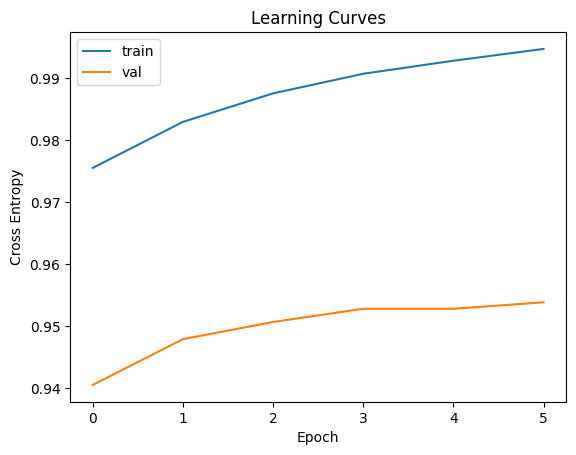

In [24]:
from matplotlib import pyplot

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.legend()
pyplot.show()

In [42]:
#Evaluate the model performance on test data
bilstm_score = bilstm_model.evaluate(X_test_padded, y_test_encoded, batch_size = 32)

50/50 [==============================] - 0s 4ms/step - loss: 0.1812 - accuracy: 0.9539


In [46]:
label_list = list(y_tokenizer.word_index.keys())
index_list = list(y_tokenizer.word_index.values())

#Input sentence
sentence = "Book me a Greek restaurant in Toronto"
input_seq = tokenizer.texts_to_sequences([sentence])
input_features = pad_sequences(input_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

#Predict the slots
prediction = bilstm_model.predict(input_features)
slots = [label_list[index_list.index(j)] for j in [np.argmax(x) for x in prediction[0][:]] if j in index_list]
print(sentence)
print(slots)

1/1 [==============================] - 0s 35ms/step
Book me a Greek restaurant in Toronto
['O', 'O', 'O', 'B-cuisine', 'B-restaurant_type', 'O', 'B-city']
